In [1]:
import uproot
import awkward as ak
import numpy as np
import vector
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score
import pickle

In [2]:
tag = "_R_10k"

In [3]:
# Open Pythia file
with uproot.open("../pythia/dataset"+tag+".root:fastjet") as f:
    #print(f.keys())
    jet_pt = f['jet_pt'].array()
    jet_eta = f['jet_eta'].array()
    jet_phi = f['jet_phi'].array()
    jet_m = f['jet_m'].array()
    
    jet_trk_pt = f['jet_trk_pt'].array()
    jet_trk_eta = f['jet_trk_eta'].array()
    jet_trk_phi = f['jet_trk_phi'].array()
    jet_trk_q = f['jet_trk_q'].array()
    jet_trk_d0 = f['jet_trk_d0'].array()
    jet_trk_z0 = f['jet_trk_z0'].array()
    jet_trk_pid = f['jet_trk_pid'].array()
    jet_trk_origin = f['jet_trk_origin'].array()
    
    trk_pt = f['trk_pt'].array()
    trk_eta = f['trk_eta'].array()
    trk_phi = f['trk_phi'].array()
    trk_q = f['trk_q'].array()
    trk_d0 = f['trk_d0'].array()
    trk_z0 = f['trk_z0'].array()
    trk_pid = f['trk_pid'].array()
    trk_origin = f['trk_origin'].array()

In [4]:
with uproot.open("../madgraph/labels"+tag+".root:labels") as f:
    #print(f.keys())
    top_px = f['top_px'].array()
    top_py = f['top_py'].array()
    top_pz = f['top_pz'].array()
    top_E = f['top_E'].array()
    down_px = f['down_px'].array()
    down_py = f['down_py'].array()
    down_pz = f['down_pz'].array()
    costheta = f['costheta'].array()

In [5]:
# Initialize output features
selected_events = []

# Jet Feats
selected_jet_pt = []
selected_jet_eta = []
selected_jet_phi = []
selected_jet_m = []

# Trk Feats
selected_trk_pt = []
selected_trk_eta = []
selected_trk_phi = []
selected_trk_q = []
selected_trk_d0 = []
selected_trk_z0 = []
selected_trk_pid = []
selected_trk_origin = []

In [6]:
deltaR_cut = 1.0

In [7]:
#%%time
# Initialize lists for plotting
pt_partons = []
pt_fat_jets = []
deltaR = []
deltaEta = []
deltaPhi = []

unweighted_origins = []
weighted_origins = []

missing_jet=0
cutflow_deltaR=0

# Loop over all events
num_events=len(jet_pt)
for i in range(num_events):

    if i%100==0:
        print("\tProcessing: ", i, " / ", len(jet_pt), end="\r")

    # Ensure at least one fat jet
    if len(jet_pt[i])<1:
        missing_jet+=1
        selected_events.append(False)
        continue

    # Save parton 3-Vector
    parton = vector.MomentumObject3D(px=top_px[i], py=top_py[i], pz=top_pz[i])

    # Find closest fat jet in deltaR
    delR = []
    for j in range(len(jet_pt[i])):
        delR.append(parton.deltaR(vector.MomentumObject3D(pt=jet_pt[i][j], eta=jet_eta[i][j], phi=jet_phi[i][j])))
    argmin = np.argmin(delR)

    candidate = vector.MomentumObject3D(pt=jet_pt[i][argmin], eta=jet_eta[i][argmin], phi=jet_phi[i][argmin])

    if abs(parton.deltaR(candidate))>deltaR_cut:
        cutflow_deltaR+=1
        selected_events.append(False)
        continue

    # Closest jet in deltaR to parton is matched jet
    matched_jet = candidate
    selected_events.append(True)

    # Fill lists for plotting
    pt_partons.append(parton.pt)
    pt_fat_jets.append(matched_jet.pt)
    deltaR.append(parton.deltaR(matched_jet))
    deltaEta.append(parton.deltaeta(matched_jet))
    deltaPhi.append(parton.deltaphi(matched_jet))
    
    # Calculate Truth Origins
    weights = jet_trk_pt[i][argmin]
    origins = jet_trk_origin[i][argmin]
    fromTop = origins==6 
    fromW = origins==24
    fromHadronic=fromTop|fromW
    unweighted = ak.mean(fromHadronic,axis=0)
    weighted = ak.mean(fromHadronic,axis=0,weight=weights)
    unweighted_origins.append(unweighted)
    weighted_origins.append(weighted)
    
    # Fill output vars
    # Jet Feats
    selected_jet_pt.append(jet_pt[i][argmin])
    selected_jet_eta.append(jet_eta[i][argmin])
    selected_jet_phi.append(jet_phi[i][argmin])
    selected_jet_m.append(jet_m[i][argmin])

    # Trk Feats
    selected_trk_pt.append(jet_trk_pt[i][argmin])
    selected_trk_eta.append(jet_trk_eta[i][argmin])
    selected_trk_phi.append(jet_trk_phi[i][argmin])
    selected_trk_q.append(jet_trk_q[i][argmin])
    selected_trk_d0.append(jet_trk_d0[i][argmin])
    selected_trk_z0.append(jet_trk_z0[i][argmin])
    selected_trk_pid.append(jet_trk_pid[i][argmin])
    selected_trk_origin.append(jet_trk_origin[i][argmin])
    
print("\tEvents without reco jet: ", missing_jet, "/", num_events)
print("\tDeltaR Cutflow: ", cutflow_deltaR, "/", num_events-missing_jet)
print()

	Events without reco jet:  4905 / 10000
	DeltaR Cutflow:  2220 / 5095



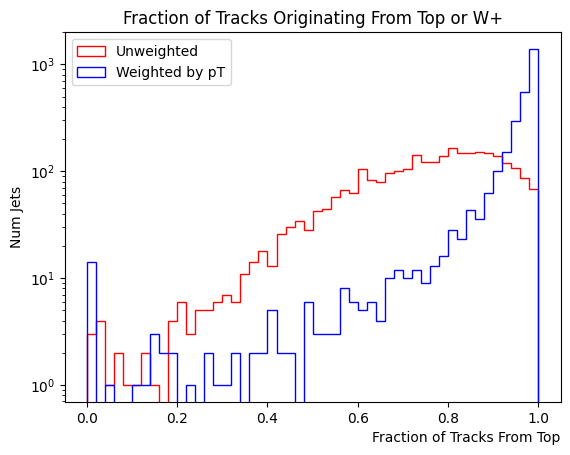

In [8]:
plt.title("Fraction of Tracks Originating From Top or W+")
plt.hist(unweighted_origins,bins=50,range=(0,1),color='r',histtype='step',label="Unweighted")
plt.hist(weighted_origins,bins=50,range=(0,1),color='b',histtype='step',label="Weighted by pT")
plt.yscale('log')
plt.ylabel('Num Jets')
plt.xlabel('Fraction of Tracks From Top',loc='right')
plt.legend()
plt.show()

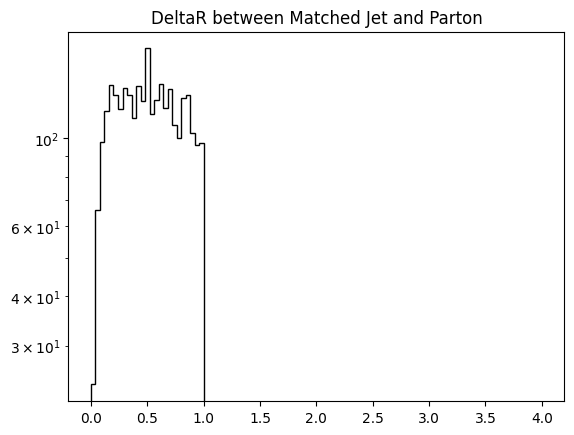

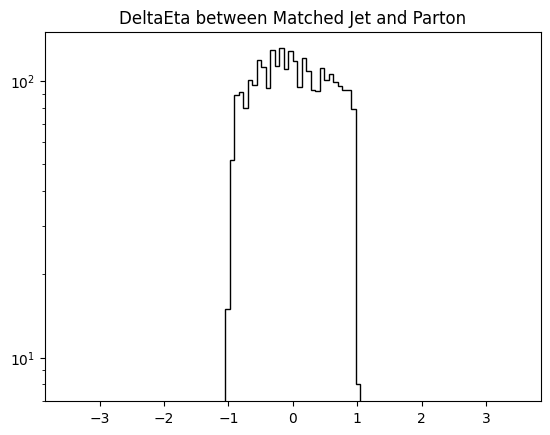

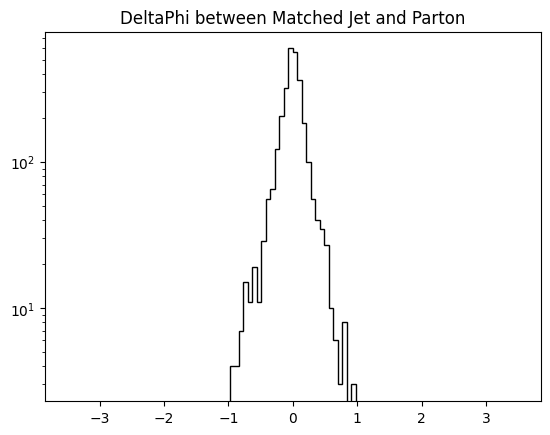

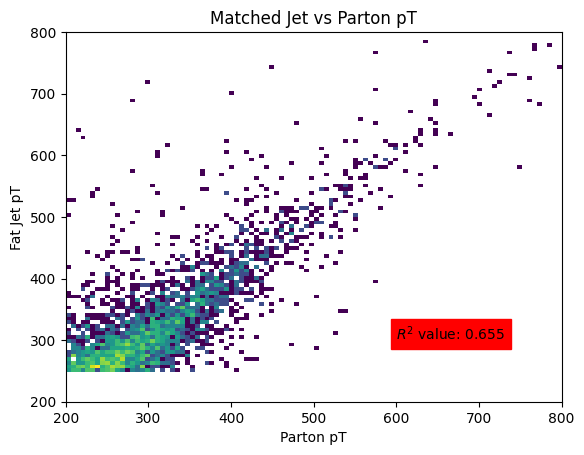

In [9]:
#fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
    
fig1, ax1 = plt.subplots()
ax1.set_title("Matched Jet vs Parton pT")
ax1.hist2d(pt_partons,pt_fat_jets, bins=100,norm=mcolors.LogNorm(),range=((200,800),(200,800)))
ax1.set_xlabel("Parton pT")
ax1.set_ylabel("Fat Jet pT")
ax1.text(600,300,"$R^2$ value: "+str(round(r2_score(pt_partons,pt_fat_jets),3)),backgroundcolor='r',color='k')

ax2.set_title("DeltaR between Matched Jet and Parton")
ax2.hist(deltaR,histtype='step',bins=100,range=(0,4),color='k')
ax2.set_yscale("log")
#ax2.legend()

ax3.set_title("DeltaEta between Matched Jet and Parton")
ax3.hist(deltaEta,histtype='step',bins=100,range=(-3.5,3.5),color='k')
ax3.set_yscale("log")
#ax3.legend()

ax4.set_title("DeltaPhi between Matched Jet and Parton")
ax4.hist(deltaPhi,histtype='step',bins=100,range=(-3.5,3.5),color='k')
ax4.set_yscale("log")
#ax4.legend()
    
plt.show()

In [10]:
# Jet Feats
jet_pt = ak.Array(selected_jet_pt)
jet_eta = ak.Array(selected_jet_eta)
jet_phi = ak.Array(selected_jet_phi)
jet_m = ak.Array(selected_jet_m)

# Trk Feats
jet_trk_pt = ak.Array(selected_trk_pt)
jet_trk_eta = ak.Array(selected_trk_eta)
jet_trk_phi = ak.Array(selected_trk_phi)
jet_trk_q = ak.Array(selected_trk_q)
jet_trk_d0 = ak.Array(selected_trk_d0)
jet_trk_z0 = ak.Array(selected_trk_z0)
jet_trk_pid = ak.Array(selected_trk_pid)
jet_trk_origin = ak.Array(selected_trk_origin)

# Global Trk Feats
trk_pt = trk_pt[selected_events]
trk_eta = trk_eta[selected_events]
trk_phi = trk_phi[selected_events]
trk_q = trk_q[selected_events]
trk_d0 = trk_d0[selected_events]
trk_z0 = trk_z0[selected_events]
trk_pid = trk_pid[selected_events]
trk_origin = trk_origin[selected_events]

# Label
top_px = top_px[selected_events]
top_py = top_py[selected_events]
top_pz = top_pz[selected_events]
top_E = top_E[selected_events]
down_px = down_px[selected_events]
down_py = down_py[selected_events]
down_pz = down_pz[selected_events]
costheta = costheta[selected_events]

In [11]:
norm = False
if norm:
    jet_pt = (jet_pt-ak.mean(jet_pt))/ak.std(jet_pt)
    jet_eta = (jet_eta-ak.mean(jet_eta))/ak.std(jet_eta)
    jet_phi = (jet_phi-ak.mean(jet_phi))/ak.std(jet_phi)
    jet_m = (jet_m-ak.mean(jet_m))/ak.std(jet_m)
    
    jet_trk_pt = (jet_trk_pt-ak.mean(jet_trk_pt))/ak.std(jet_trk_pt)
    jet_trk_eta = (jet_trk_eta-ak.mean(jet_trk_eta))/ak.std(jet_trk_eta)
    jet_trk_phi = (jet_trk_phi-ak.mean(jet_trk_phi))/ak.std(jet_trk_phi)
    jet_trk_q = (jet_trk_q-ak.mean(jet_trk_q))/ak.std(jet_trk_q)
    jet_trk_d0 = (jet_trk_d0-ak.mean(jet_trk_d0))/ak.std(jet_trk_d0)
    jet_trk_z0 = (jet_trk_z0-ak.mean(jet_trk_z0))/ak.std(jet_trk_z0)
    
    trk_pt = (trk_pt-ak.mean(trk_pt))/ak.std(trk_pt)
    trk_eta = (trk_eta-ak.mean(trk_eta))/ak.std(trk_eta)
    trk_phi = (trk_phi-ak.mean(trk_phi))/ak.std(trk_phi)
    trk_q = (trk_q-ak.mean(trk_q))/ak.std(trk_q)
    trk_d0 = (trk_d0-ak.mean(trk_d0))/ak.std(trk_d0)
    trk_z0 = (trk_z0-ak.mean(trk_z0))/ak.std(trk_z0)

In [12]:
jet_feat_list = [jet_pt,jet_eta,jet_phi,jet_m]
jet_feat_list = [x[:,np.newaxis] for x in jet_feat_list]
jet_feats = ak.concatenate(jet_feat_list, axis=1)

In [13]:
jet_trk_feat_list = [jet_trk_pt,jet_trk_eta,jet_trk_phi,jet_trk_q,jet_trk_d0,jet_trk_z0,jet_trk_pid,jet_trk_origin]
jet_trk_feat_list = [x[:,:,np.newaxis] for x in jet_trk_feat_list]
jet_trk_feats = ak.concatenate(jet_trk_feat_list, axis=2)

In [14]:
trk_feat_list = [trk_pt,trk_eta,trk_phi,trk_q,trk_d0,trk_z0,trk_pid,trk_origin]
trk_feat_list = [x[:,:,np.newaxis] for x in trk_feat_list]
trk_feats = ak.concatenate(trk_feat_list, axis=2)

In [15]:
label_list = [top_px,top_py,top_pz,top_E,down_px,down_py,down_pz,costheta]
label_list = [x[:,np.newaxis] for x in label_list]
labels = ak.concatenate(label_list, axis=1)

In [16]:
data_dict = {"jet_feats": jet_feats,
             "jet_trk_feats": jet_trk_feats,
             "trk_feats": trk_feats,
             "labels": labels,
            }

with open("data"+tag+".pkl","wb") as f:
    pickle.dump(data_dict, f)

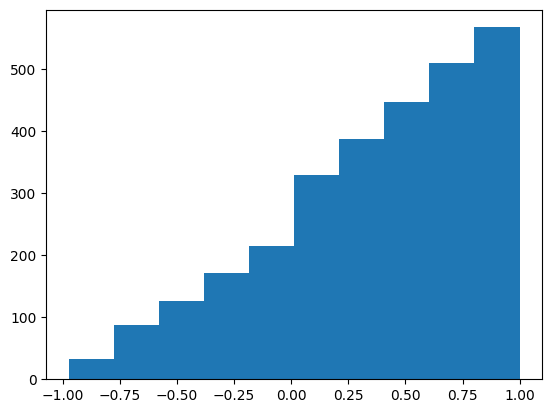

In [17]:
plt.hist(costheta)
plt.show()